<a href="https://colab.research.google.com/github/YapingWu/GoogleColab/blob/main/genpass_from_github.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# github代码复制到google colab

参考资料：
1. https://techsupportallbugs.wordpress.com/2018/06/05/using-git-with-colab-via-ssh/

## 配置SSH
1. **上传压缩后的密钥对文件和配置文件**
1. 将密钥对文件和配置文件解压到/root/.ssh文件夹中
2. 将私钥加载到本地ssh-agent中
3. 设置git账户

In [ ]:
!rm -rf ~/.ssh
!unzip '/content/ssh-colab.zip' -d ~/.ssh
!chmod 700 ~/.ssh

# add the ssh server as a hnown host
!touch ~/.ssh/known_hosts
!ssh-keyscan github.com >> ~/.ssh/known_hosts
!chmod 644 ~/.ssh/known_hosts

In [ ]:
!ssh-agent /bin/bash 

# 以下命令在ssh-agent启动的shell中执行
# chmod 600 ~/.ssh/id_rsa_colab  # 私钥需要设置仅自己可以访问，才能添加到代理
# ssh-add ~/.ssh/id_rsa_colab
# ssh-add -l
# exit

In [ ]:
!git config --global user.name 'colab'
!git config --global user.email 'vyapings@163.com'

## clone私有库
1. 安装google云盘
2. 将工作目录更改为云端硬盘内的文件夹
3. 运行git clone。

In [ ]:
from google.colab import drive
drive.mount('./drive')

import os
os.chdir('/content/drive/MyDrive/gen_pass')

!pwd
!ls

In [ ]:
# !rm -rf gen_pass
# !git clone git@github.com:YapingWu/gen_pass.git

!git stash
!git stash clear
!git pull origin master

# 运行genpass项目

In [ ]:
# 修改时区
!date -R
import os
os.environ['TZ'] = "Asia/Shanghai"
!date -R

# 修改工作目录
import os
print(os.getcwd())
os.chdir('/content/drive/MyDrive/gen_pass')
print(os.getcwd())

## 数据分析

In [ ]:
!python main.py \
  -e pro \
  --stats-only

## 数据预处理

In [ ]:
!python main.py \
  -e pro \
  --pre-processing-only

## 训练word-level LSTM

### 训练分词器

In [ ]:
!python main.py \
  -e pro \
  --train --model tokenizer

### 使用pcfg编码结果训练LSTM模型

In [ ]:
!python main.py \
    -e pro \
    --train \
    --model lstm

## 训练char-level CNN

In [ ]:
!python main.py \
    -e pro \
    --train \
    --model cnn

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir 'logs/cnn/cnn210327230105'

## 生成密码

### 使用genpass模型生成密码

In [ ]:
# 使用genpass模型生成密码
!python main.py \
  -e pro \
  --generate --model genpass \
  -c 0.3 \
  --alphas 3 4 5 \
  --chunk 10000

!python main.py \
  -e pro \
  --generate --model genpass \
  -c 0.3 \
  --alphas 6 \
  --chunk 10000

### 使用PL模型生成密码

In [ ]:
!python main.py \
  -e default \
  --generate --model pl \
  --dnames myspace phpbb myspace_part phpbb_part\
  --alphas 3 4 5 \
  --chunk 100000

!python main.py \
  -e default \
  --generate --model pl \
  --dnames myspace phpbb myspace_part phpbb_part\
  --alphas 6 \
  --chunk 100000

## 评估模型

### genpass模型

In [ ]:
!python main.py \
    -e pro \
    --evaluate --model genpass \
    --alphas 3 4 5 6 \
    -c 0.3

### PL模型

In [ ]:
!python main.py \
    -e pro \
    --evaluate --model pl \
    --test-size 7000 \
    --alphas 3 4 5 6

### 画图

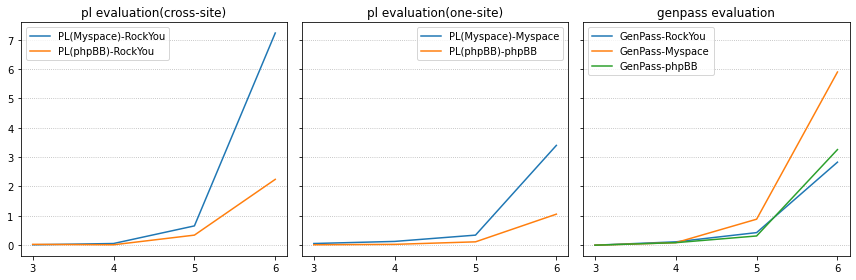

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def draw_line(x, y, label):
  fig, ax = plt.subplots(1, 3, figsize=(12, 4), sharex='all', sharey='all')
  plt.xticks(x)

  for i in [0, 1, 2]:
      for y_, label_ in zip(y[i], label[i]):
          ax[i].plot(x, y_, label=label_)

      ax[i].grid(axis='y', linestyle='dotted')
      ax[i].legend()

  ax[0].set_title("pl evaluation(cross-site)")
  ax[1].set_title("pl evaluation(one-site)")
  ax[2].set_title("genpass evaluation")

  fig.tight_layout()

  plt.show()



eva_pl = pd.read_csv('result/eva/eva_pl_210331183902.txt',
                     converters={'mr': eval})
eva_genpass = pd.read_csv('result/eva/eva_genpass_210331183719.txt',
                     converters={'mr': eval})
pl_cross = eva_pl.loc[:1]
pl_one = eva_pl.loc[2:]

x = [3, 4, 5, 6]
y = [pl_cross['mr'].to_list(), pl_one['mr'].to_list(), eva_genpass['mr'].to_list()]
label = [pl_cross['desc'].to_list(), pl_one['desc'].to_list(), eva_genpass['desc'].to_list()]

draw_line(x, y, label)
